In [4]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [5]:
from pprint import pprint

from pymoo.optimize import minimize

from src.constants import SEED
from src.nas.nas import NasParams
from src.nas.plot import hist_accuracies


In [ ]:
from src.nas.cnn_chromosome import CNNChromosome, RawCNNChromosome

pprint(RawCNNChromosome.get_size())
pprint(RawCNNChromosome.get_bounds())

26
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0]),
 array([7, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 7, 3, 7, 3, 7, 2, 3, 3, 0,
       1, 1, 6, 3]))


In [ ]:
from src.datasets.mnist_dataset import MiniMNISTDataset
from src.nas.cnn_nas_problem import CnnNasProblem


CnnDatasetClass = MiniMNISTDataset
cnn_nas_params = NasParams(
    epochs=1,
    patience=5,
    amount_of_evaluations=1,
    population_size=20,
    population_offspring_count=8,
    algorithm_generations=1,
    population_store_file=CnnDatasetClass.__name__ + "_population.csv",
)
cnn_problem = CnnNasProblem(cnn_nas_params, CnnDatasetClass)

cnn_problem.get_min_complexity(), cnn_problem.get_max_complexity()

(229672.0, 1454520.0)

In [8]:
from src.models.cnn import CNN, CNNEvaluator

x = [7, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0]
cnn_ch = RawCNNChromosome(x).parse()
pprint(cnn_ch)

CNNChromosome(in_bitwidth=8,
              conv_layers=2,
              conv_channels1=16,
              conv_stride1=1,
              conv_pooling_size1=1,
              conv_channels2=32,
              conv_stride2=1,
              conv_pooling_size2=2,
              conv_channels3=16,
              conv_stride3=1,
              conv_pooling_size3=1,
              fc_layers=3,
              fc_height1=32,
              fc_bitwidth1=1,
              fc_height2=32,
              fc_bitwidth2=1,
              fc_height3=32,
              fc_bitwidth3=1,
              dropout=0.0,
              activation=<ActivationModule.BINARIZE_RESTE: 'binary_ReSTE'>,
              reste_o=1.5,
              reste_threshold=1.5,
              quatization_mode=<QMode.DET: 'det'>,
              binarization_mode=<QMode.DET: 'det'>,
              learning_rate=0.0001,
              weight_decay=0.01)


In [9]:
cnn_params = cnn_problem.get_nn_params(cnn_ch)
CNN(cnn_params)

CNN(
  (in_quantize_layer): Module_Quantize()
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Binary_ReSTE_Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Module_Binarize_ReSTE()
    )
    (1): Sequential(
      (0): Binary_ReSTE_Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Module_Binarize_ReSTE()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_layers): Sequential(
    (0): QuantizedWeightLinear(in_features=4608, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Module_Binarize_ReSTE()
    (3): QuantizedWeightLinear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [10]:
CNNEvaluator(cnn_params).evaluate_model()

{'max': 10.0, 'mean': np.float64(10.0), 'std': np.float64(0.0)}

In [ ]:
algorithm = cnn_nas_params.get_algorithm()
termination = cnn_nas_params.get_termination()

res = minimize(cnn_problem, algorithm, verbose=True, seed=SEED, termination=termination)

if cnn_nas_params.population_store_file is not None:
    cnn_nas_params.store_population(res, cnn_nas_params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file loaded successfully


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        7 |      6 |             - |             -
Solutions: [[3 1 1 0 1 0 1 1 2 0 1 0 2 2 2 1 1 0 2 0 3 0 1 1 2 3]
 [0 0 0 0 1 2 1 1 0 1 1 0 2 1 1 0 3 6 0 3 3 0 1 0 6 0]
 [0 2 2 1 1 1 0 0 2 0 0 2 2 2 2 3 1 7 0 0 0 0 0 0 5 3]
 [1 1 0 0 1 0 0 0 2 1 1 0 3 4 3 4 1 5 2 0 2 0 1 0 2 2]
 [4 1 2 1 0 1 1 0 2 1 0 0 1 7 2 6 1 4 0 2 2 0 0 0 4 0]
 [4 1 1 0 1 0 0 0 2 1 0 0 1 2 3 6 1 4 1 2 1 0 1 0 5 3]]
Objectives: [[-0.3675      0.          0.10714286]
 [-0.445       0.32382271  0.        ]
 [-0.77125     0.          0.42857143]
 [-0.46125     1.          0.10714286]
 [-0.44625     0.00562682  0.32142857]
 [-0.57        0.23840264  0.14285714]]


In [12]:
df = cnn_problem.result_as_df(res)
df

,Accuracy,Complexity,conv_in_channels,conv_in_dimensions,conv_in_bitwidth,conv_out_height,conv_layers,conv_activation,conv_reste_threshold,conv_reste_o,...,conv_dropout_rate,fc_layers,fc_activation,fc_qmode,fc_dropout_rate,train_epochs,train_learning_rate,train_weight_decay,train_early_stop_patience,Chromosome
0,36.750,2.296720e+05,1,28,4,10,"[{'channels': 24, 'kernel_size': 3, 'stride': ...",ActivationModule.RELU,1.5,4.0,...,0.2,"[{'height': 784, 'weight_qmode': WeightQuantMo...","{'activation': ActivationModule.RELU, 'binary_...",QMode.STOCH,0.2,1,0.0005,0.001,5,"[3, 1, 1, 0, 1, 0, 1, 1, 2, 0, 1, 0, 2, 2, 2, ..."
1,44.500,6.263056e+05,1,28,1,10,"[{'channels': 16, 'kernel_size': 3, 'stride': ...",ActivationModule.TERNARIZE,1.5,4.0,...,0.0,"[{'height': 784, 'weight_qmode': WeightQuantMo...","{'activation': ActivationModule.TERNARIZE, 'bi...",QMode.STOCH,0.0,1,0.0100,0.010,5,"[0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, ..."
2,77.125,2.296720e+05,1,28,1,10,"[{'channels': 32, 'kernel_size': 3, 'stride': ...",ActivationModule.RELU,1.5,1.5,...,0.0,"[{'height': 784, 'weight_qmode': WeightQuantMo...","{'activation': ActivationModule.RELU, 'binary_...",QMode.DET,0.0,1,0.0050,0.001,5,"[0, 2, 2, 1, 1, 1, 0, 0, 2, 0, 0, 2, 2, 2, 2, ..."
3,46.125,1.454520e+06,1,28,2,10,"[{'channels': 16, 'kernel_size': 3, 'stride': ...",ActivationModule.RELU,1.5,3.0,...,0.2,"[{'height': 784, 'weight_qmode': WeightQuantMo...","{'activation': ActivationModule.RELU, 'binary_...",QMode.STOCH,0.2,1,0.0005,0.002,5,"[1, 1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 3, 4, 3, ..."
4,44.625,2.365640e+05,1,28,5,10,"[{'channels': 32, 'kernel_size': 3, 'stride': ...",ActivationModule.BINARIZE_RESTE,1.5,3.0,...,0.0,"[{'height': 784, 'weight_qmode': WeightQuantMo...",{'activation': ActivationModule.BINARIZE_RESTE...,QMode.DET,0.0,1,0.0020,0.010,5,"[4, 1, 2, 1, 0, 1, 1, 0, 2, 1, 0, 0, 1, 7, 2, ..."
5,57.000,5.216790e+05,1,28,5,10,"[{'channels': 24, 'kernel_size': 3, 'stride': ...",ActivationModule.BINARIZE_RESTE,1.5,2.0,...,0.1,"[{'height': 784, 'weight_qmode': WeightQuantMo...",{'activation': ActivationModule.BINARIZE_RESTE...,QMode.STOCH,0.1,1,0.0050,0.001,5,"[4, 1, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 1, 2, 3, ..."


In [13]:
pprint(cnn_problem.get_nn_params(RawCNNChromosome(res.X[0]).parse()))

CNNParams(conv=ConvParams(in_channels=1,
                          in_dimensions=28,
                          in_bitwidth=4,
                          out_height=10,
                          layers=[ConvLayerParams(channels=24,
                                                  kernel_size=3,
                                                  stride=1,
                                                  padding=0,
                                                  dilation=1,
                                                  groups=1,
                                                  bias=True,
                                                  pooling_kernel_size=2),
                                  ConvLayerParams(channels=16,
                                                  kernel_size=3,
                                                  stride=2,
                                                  padding=0,
                                                  dilation=1,
                

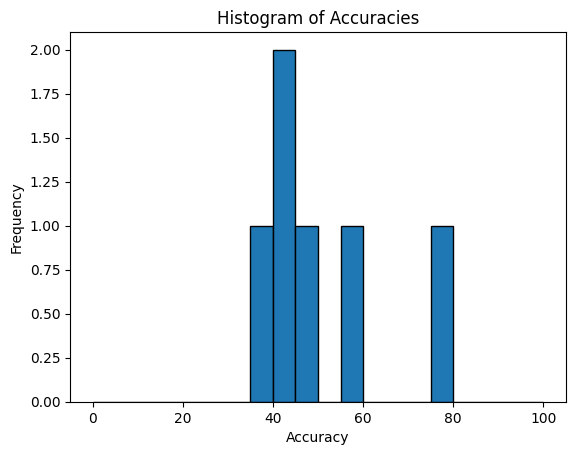

In [14]:
fig = hist_accuracies(df["Accuracy"])

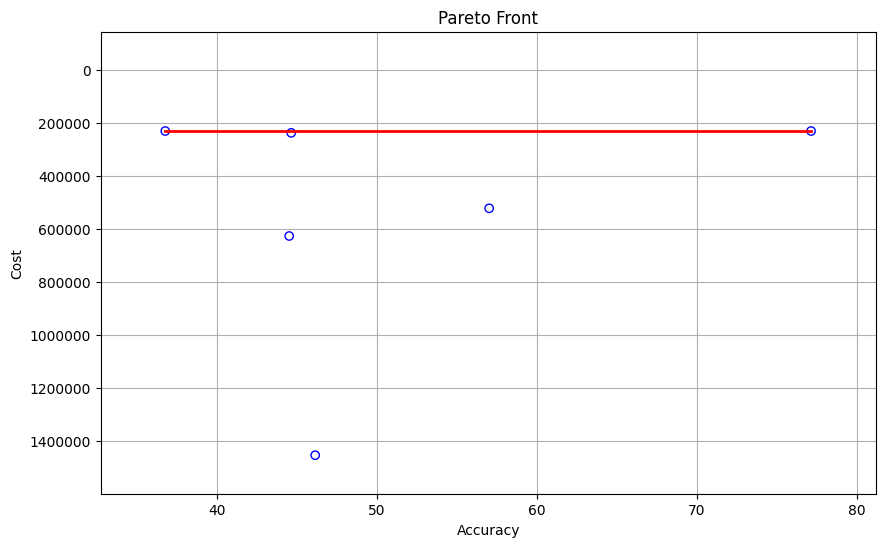

In [15]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])

In [26]:
pprint(RawCNNChromosome(df.iloc[2]["Chromosome"]).parse())

df.iloc[2]["Accuracy"]

CNNChromosome(in_bitwidth=1,
              conv_layers=3,
              conv_channels1=32,
              conv_stride1=2,
              conv_pooling_size1=2,
              conv_channels2=24,
              conv_stride2=1,
              conv_pooling_size2=1,
              conv_channels3=32,
              conv_stride3=1,
              conv_pooling_size3=1,
              fc_layers=3,
              fc_height1=64,
              fc_bitwidth1=3,
              fc_height2=64,
              fc_bitwidth2=4,
              fc_height3=32,
              fc_bitwidth3=8,
              dropout=0.0,
              activation=<ActivationModule.RELU: 'relu'>,
              reste_o=1.5,
              reste_threshold=1.5,
              quatization_mode=<QMode.DET: 'det'>,
              binarization_mode=<QMode.DET: 'det'>,
              learning_rate=0.005,
              weight_decay=0.001)


np.float64(81.375)

In [27]:
pprint(RawCNNChromosome(df.iloc[4]["Chromosome"]).parse())

df.iloc[4]["Accuracy"]

CNNChromosome(in_bitwidth=5,
              conv_layers=2,
              conv_channels1=32,
              conv_stride1=2,
              conv_pooling_size1=1,
              conv_channels2=24,
              conv_stride2=2,
              conv_pooling_size2=1,
              conv_channels3=32,
              conv_stride3=2,
              conv_pooling_size3=1,
              fc_layers=1,
              fc_height1=32,
              fc_bitwidth1=8,
              fc_height2=64,
              fc_bitwidth2=7,
              fc_height3=32,
              fc_bitwidth3=5,
              dropout=0.0,
              activation=<ActivationModule.BINARIZE_RESTE: 'binary_ReSTE'>,
              reste_o=3.0,
              reste_threshold=1.5,
              quatization_mode=<QMode.DET: 'det'>,
              binarization_mode=<QMode.DET: 'det'>,
              learning_rate=0.002,
              weight_decay=0.01)


np.float64(43.125)